In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
az.style.use("arviz-darkgrid")
SEED=1

In [3]:
diseased_means = np.array([2.80549926, 2.79666096, 2.9869277,  3.962205])

diseased_cov = np.array([[ 0.19818925,  0.00432564, -0.02196359,  0.01666092],
 [ 0.00432564,  0.21659711, -0.02382195, -0.00258357],
 [-0.02196359, -0.02382195,  0.07842352,  0.02014519],
 [ 0.01666092, -0.00258357,  0.02014519,  0.0301144 ]])

healthy_means = np.array([2.3076398,  3.33769212, 3.19855357, 3.90669097])

healthy_cov = np.array([[ 0.08162375,  0.03669294,  0.01955666,  0.02087333],
 [ 0.03669294,  0.23478904, -0.02114343, -0.01991113],
 [ 0.01955666, -0.02114343,  0.04190113,  0.01566071],
 [ 0.02087333, -0.01991113,  0.01566071,  0.02848467]])

genes = ['A','B','C','D']

rng = np.random.default_rng(SEED)

diseased_samples = pd.DataFrame(rng.multivariate_normal(diseased_means, diseased_cov, 20), columns=genes).assign(Dx=True)
healthy_samples = pd.DataFrame(rng.multivariate_normal(healthy_means, healthy_cov, 20), columns=genes).assign(Dx=False)
patients = pd.concat([diseased_samples,healthy_samples], ignore_index=True)

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self.fig.tight_layout(*args, **kwargs)


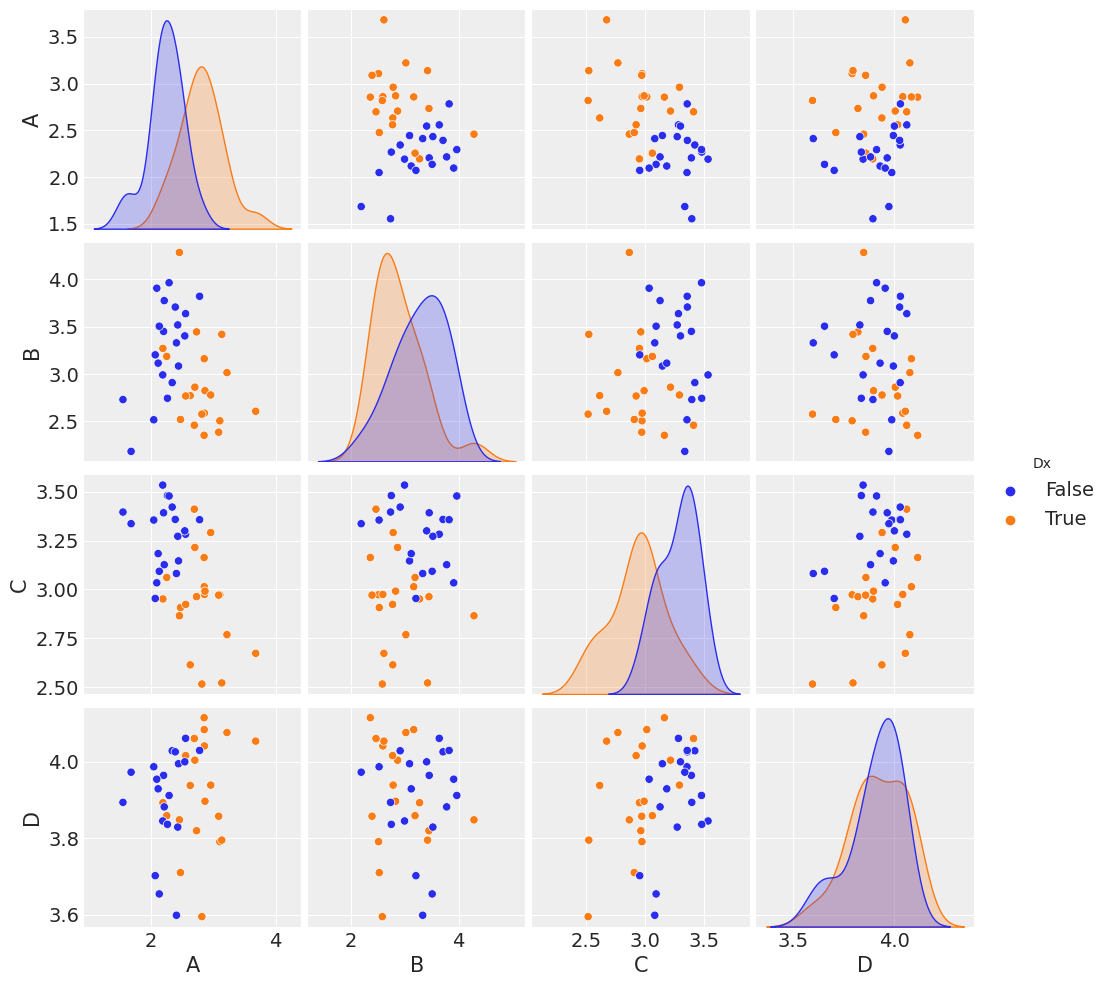

In [4]:
sns.pairplot(patients, hue='Dx')

In [5]:
patients_means = patients[genes].mean(0)
cntr_patients = patients.copy()
cntr_patients[genes] = cntr_patients[genes] - patients_means
patients_means

A    2.523901
B    3.082775
C    3.108742
D    3.912432
dtype: float64

In [6]:
cntr_patients.head()

,A,B,C,D,Dx
0,0.582543,-0.575459,-0.135688,-0.121367,True
1,0.330818,-0.728639,0.054388,0.202846,True
2,0.335780,-0.494823,-0.134017,0.128997,True
3,0.332867,0.079791,-0.094507,0.171785,True
4,0.182319,-0.220569,0.106031,0.091745,True


In [7]:
bmb_model = bmb.Model('Dx ~ 0 + ' + ' + '.join(genes), cntr_patients, family="bernoulli")

# Fit the model using 10000 on each of 4 chains
bmb_idata = bmb_model.fit(draws=10000, chains=4, random_seed=SEED)

Modeling the probability that Dx==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [D, C, B, A]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 26 seconds.


In [8]:
bmb_model.predict(bmb_idata, kind='pps')

# compute pointwise LOO
loo = az.loo(bmb_idata, pointwise=True)

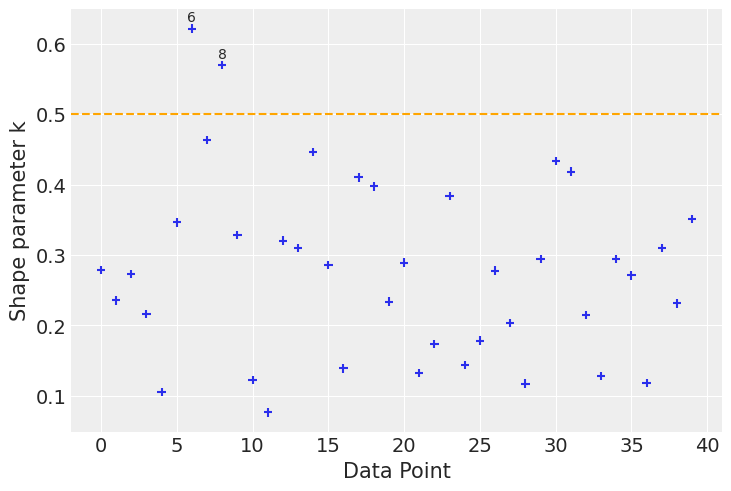

In [9]:
ax = az.plot_khat(loo.pareto_k)
sorted_kappas = np.sort(loo.pareto_k.values.ravel())

# find observation where the kappa value exceeds the threshold
threshold = 0.5
ax.axhline(threshold, ls="--", color="orange")
influential_observations = cntr_patients.reset_index()[loo.pareto_k.values >= threshold].index

for x in influential_observations:
    y = loo.pareto_k.values[x]
    ax.text(x, y + 0.01, str(x), ha="center", va="baseline")

In [10]:
outliers = patients[loo.pareto_k.values>=threshold].index
patients[loo.pareto_k.values>=threshold]

,A,B,C,D,Dx
6,2.458574,4.284597,2.865789,3.848123,True
8,3.681139,2.607368,2.673873,4.054039,True


In [11]:
cntr_patients_f = cntr_patients.drop(index=outliers).reset_index(drop=True)
cntr_patients_f[genes] -= cntr_patients_f[genes].mean(0)

## PyMC

In [12]:
import pymc3 as pm
import theano.tensor as tt

In [13]:
bmb_model = bmb.Model('Dx ~ 0 + ' + ' + '.join(genes), cntr_patients_f, family="bernoulli")
bmb_idata = bmb_model.fit(draws=10000, chains=4, random_seed=SEED)

Modeling the probability that Dx==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [D, C, B, A]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 25 seconds.


In [14]:
prior_mus = np.zeros(len(genes))
prior_sigmas = np.array([prior['sigma'] for prior in bmb_model.scaler.priors.values()])

In [28]:
coords = {'gene': genes, 'sample': cntr_patients_f.index}
with pm.Model(coords=coords) as pm_model_1:
    data = pm.Data('data', cntr_patients_f[genes].values, dims=('sample', 'gene'))
    slopes = pm.Normal('slopes', prior_mus, prior_sigmas.flatten(), dims='gene')
    logit_p = pm.Deterministic("logit_p", pm.math.dot(data, slopes))
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    _ = pm.Bernoulli('Dx', p=p, observed=cntr_patients_f.Dx.values)
    
    pm_idata_1 = pm.sample(draws=10000, chains=4, return_inferencedata=True, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [slopes]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 23 seconds.


In [29]:
X = cntr_patients_f[genes].values
with pm.Model(coords=coords) as pm_model_2:
    slopes = pm.Normal('slopes', prior_mus, prior_sigmas.flatten(), dims='gene')
    logit_p = pm.Deterministic("logit_p", pm.math.dot(X, slopes))
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    _ = pm.Bernoulli('Dx', p=p, observed=cntr_patients_f.Dx.values)
    
    pm_idata_2 = pm.sample(draws=10000, chains=4, return_inferencedata=True, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [slopes]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 26 seconds.


In [17]:
with pm.Model() as pm_model_3:
    bA = pm.Normal("A", mu=0, sigma=prior_sigmas[0])[None]
    bB = pm.Normal("B", mu=0, sigma=prior_sigmas[1])[None]
    bC = pm.Normal("C", mu=0, sigma=prior_sigmas[2])[None]
    bD = pm.Normal("D", mu=0, sigma=prior_sigmas[3])[None]
    
    b = tt.concatenate([bA, bB, bC, bD])
    logit_p = pm.math.dot(X, b)
    p = pm.math.invlogit(logit_p)
    pm.Bernoulli("Dx", p=p, observed=cntr_patients_f.Dx.values)
    pm_idata_3 = pm.sample(draws=10000, chains=4, return_inferencedata=True, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [D, C, B, A]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.


In [18]:
with pm.Model() as pm_model_4:
    bA = pm.Normal("A", mu=0, sigma=prior_sigmas[0])
    bB = pm.Normal("B", mu=0, sigma=prior_sigmas[1])
    bC = pm.Normal("C", mu=0, sigma=prior_sigmas[2])
    bD = pm.Normal("D", mu=0, sigma=prior_sigmas[3])
    
    logit_p = bA * X[:, 0] + bB * X[:, 1] + bC * X[:, 2] + bD * X[:, 3]
    p = pm.math.invlogit(logit_p)
    pm.Bernoulli("Dx", p=p, observed=cntr_patients_f.Dx.values)
    pm_idata_4 = pm.sample(draws=10000, chains=4, return_inferencedata=True, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [D, C, B, A]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.


In [19]:
az.summary(bmb_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,6.496,2.545,1.977,11.359,0.017,0.012,24087.0,23537.0,1.0
B,-4.444,2.138,-8.523,-0.650,0.014,0.011,23702.0,20285.0,1.0
C,-14.140,5.300,-24.143,-4.531,0.036,0.027,21650.0,23638.0,1.0
D,5.348,7.206,-7.494,19.329,0.048,0.037,22881.0,22479.0,1.0


In [20]:
az.summary(pm_idata_1, var_names=["slopes"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slopes[A],5.114,1.792,1.772,8.454,0.009,0.007,39953.0,28236.0,1.0
slopes[B],-3.123,1.414,-5.784,-0.540,0.007,0.005,39603.0,29319.0,1.0
slopes[C],-6.026,2.493,-10.668,-1.321,0.012,0.009,40410.0,30231.0,1.0
slopes[D],0.481,2.954,-4.974,6.145,0.014,0.014,44160.0,31579.0,1.0


In [24]:
az.summary(pm_idata_2, var_names=["slopes"])

KeyError: 'var names: "[\'A\' \'B\' \'C\' \'D\'] are not present" in dataset'

In [22]:
az.summary(pm_idata_3, var_names=["A", "B", "C", "D"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,6.472,2.524,2.035,11.357,0.016,0.012,25723.0,23100.0,1.0
B,-4.440,2.119,-8.508,-0.678,0.014,0.011,23786.0,20007.0,1.0
C,-14.105,5.264,-24.183,-4.646,0.036,0.027,22200.0,22314.0,1.0
D,5.382,7.170,-7.452,19.254,0.047,0.037,24107.0,21354.0,1.0


In [23]:
az.summary(pm_idata_4, var_names=["A", "B", "C", "D"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,6.484,2.553,1.859,11.244,0.017,0.012,23791.0,22275.0,1.0
B,-4.447,2.117,-8.478,-0.699,0.014,0.011,23569.0,20885.0,1.0
C,-14.086,5.326,-24.362,-4.675,0.037,0.027,21709.0,23628.0,1.0
D,5.337,7.238,-7.361,19.722,0.047,0.037,23857.0,23001.0,1.0
